# 线性回归和时间序列分析

In [1]:
# plotting in jupyter notebook
from IPython.display import Image
from IPython.core.display import HTML 

In [2]:
#load an image to test
img_url= "https://www.ionos.com/digitalguide/fileadmin/DigitalGuide/Teaser/totp-t.jpg"
Image(url=img_url, width = 600, height = 300)

## 知识点

**一、线性回归**: [sklearn.linear_model.LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

**二、样条回归** [Spline regression](https://www.analyticsvidhya.com/blog/2018/03/introduction-regression-splines-python-codes/)

**三、STR分解** [Time Series Decomposition with Moving Averages](https://miningthedetails.com/blog/r/TimeSeriesDecomposition/)

**四、ARMA和ARIMA**



In [3]:
import os
from datetime import datetime

In [4]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [5]:
# load data file 
data_file = ""
for file in os.listdir():
    if file.endswith(".csv"):
        data_file = file
        break

In [6]:
# 用pandas读取数据
bitcoin_data = pd.read_csv(data_file)

In [7]:
# 显示表头
bitcoin_data.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# 去掉缺失数据
bitcoin_data.dropna(inplace=True)
bitcoin_data.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
478,1325346600,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000
547,1325350740,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411
548,1325350800,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000
1224,1325391360,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000


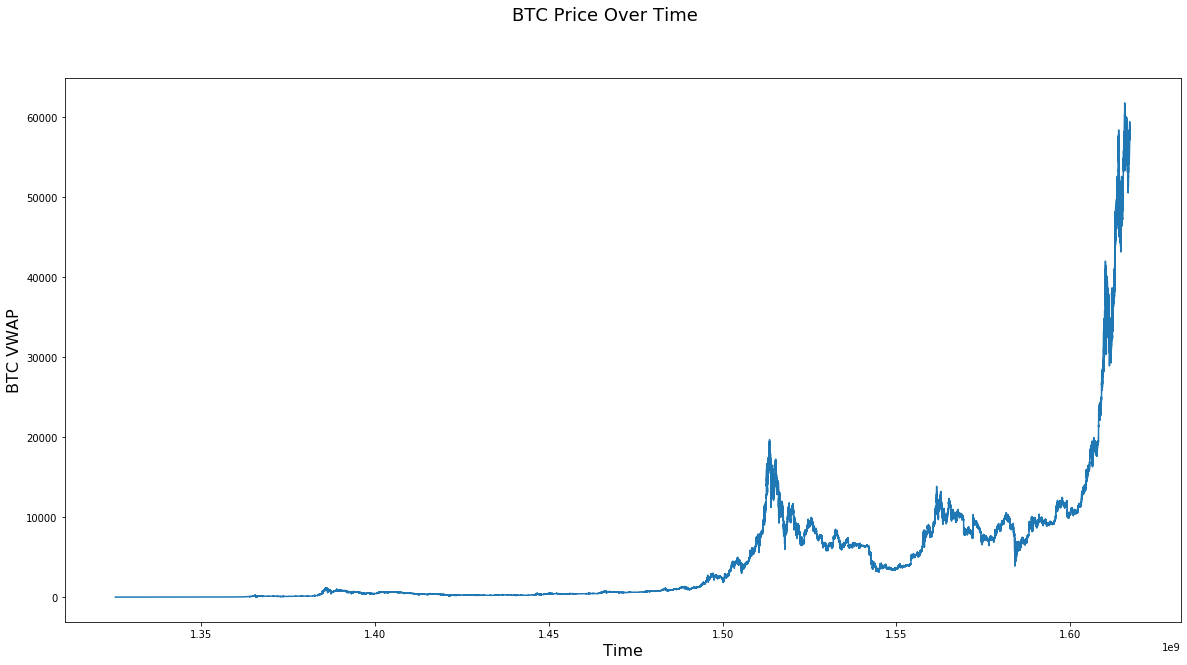

In [9]:
# 获取时间和价格
data_time = bitcoin_data['Timestamp'].values 
weighted_price = bitcoin_data['Weighted_Price'].values

# 设置画布
plt.figure(figsize=(20,10))
plt.plot(data_time,weighted_price)

# 其他参数
plt.xlabel('Time',fontsize=16)
plt.ylabel('BTC VWAP',fontsize=16)
plt.suptitle('BTC Price Over Time',fontsize=18)

plt.show()

# 线性回归

In [10]:
# linear regression
from sklearn.linear_model import LinearRegression

In [11]:
Y = bitcoin_data['Weighted_Price'].values
X = bitcoin_data['Timestamp'].values / 1e9
X

array([1.32531792, 1.3253466 , 1.32535074, ..., 1.61714868, 1.61714874,
       1.6171488 ])

In [12]:
X = X.reshape((len(X),1)) #注意sklearn 中自变量的维度

In [13]:
reg = LinearRegression(fit_intercept=True).fit(X, Y) #拟合模型

In [14]:
# R^2 
reg.score(X, Y) 

0.42345887145054184

In [15]:
reg.coef_, reg.intercept_

(array([78644.15258227]), -111791.9802947505)

In [16]:
reg.predict(X)

array([-7563.47557425, -7561.22005995, -7560.89447316, ...,
       15387.30724339, 15387.31196204, 15387.31668069])

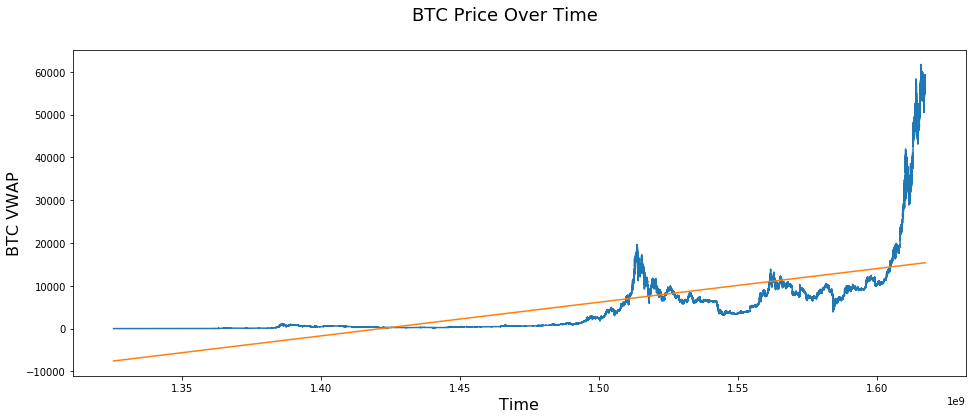

In [17]:
# 获取时间和价格
data_time = bitcoin_data['Timestamp'].values 
weighted_price = bitcoin_data['Weighted_Price'].values

# 设置画布
plt.figure(figsize=(16,6))
plt.plot(data_time,weighted_price)
plt.plot(data_time,reg.predict(X))


# 其他参数
plt.xlabel('Time',fontsize=16)
plt.ylabel('BTC VWAP',fontsize=16)
plt.suptitle('BTC Price Over Time',fontsize=18)

plt.show()

#### 线性回归评价：
It can be seen from the picture that linear regression captures the overall trend of bitcoin price increasing over time. However,the model is too simple and the price range of Bitcoin is not taken into account


# 对数线性回归

In [18]:
log_Y = np.log(Y)

In [19]:
reg_log = LinearRegression(fit_intercept=True).fit(X, log_Y)

In [20]:
# R^2 
reg_log.score(X, log_Y) 

0.847018173776573

对数线性回归的R^2大于线性回归的R^2,说明对数线性回归模型对于该数据的拟合程度更好

In [21]:
reg_log.coef_, reg_log.intercept_

(array([21.38542696]), -24.430310869944126)

In [22]:
np.exp(reg_log.predict(X))

array([   50.00778548,    50.03846637,    50.04289675, ...,
       25670.66308578, 25670.69602449, 25670.72896324])

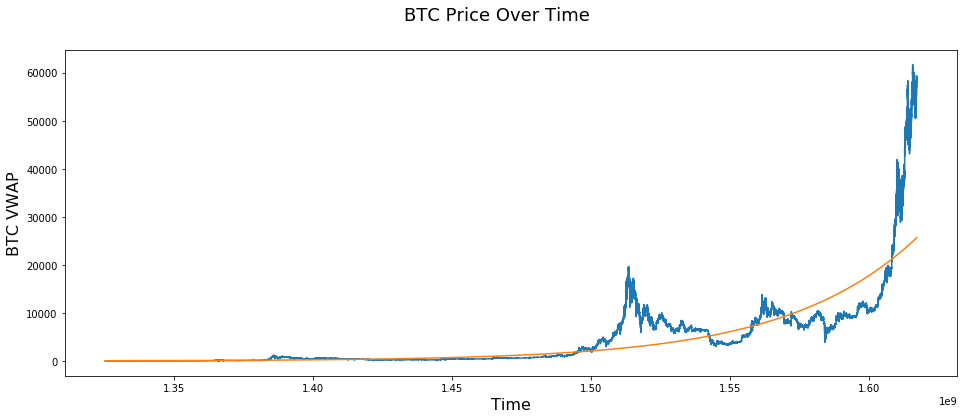

In [23]:
# 获取时间和价格
data_time = bitcoin_data['Timestamp'].values 
weighted_price = bitcoin_data['Weighted_Price'].values

# 设置画布
plt.figure(figsize=(16,6))
plt.plot(data_time,weighted_price)
plt.plot(data_time,np.exp(reg_log.predict(X)))


# 其他参数
plt.xlabel('Time',fontsize=16)
plt.ylabel('BTC VWAP',fontsize=16)
plt.suptitle('BTC Price Over Time',fontsize=18)

plt.show()

# 样条回归

In [24]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [25]:
model = make_pipeline(PolynomialFeatures(3), Ridge())
model

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [26]:
model.fit(X, Y)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [27]:
model.score(X,Y)

0.5698104554030197

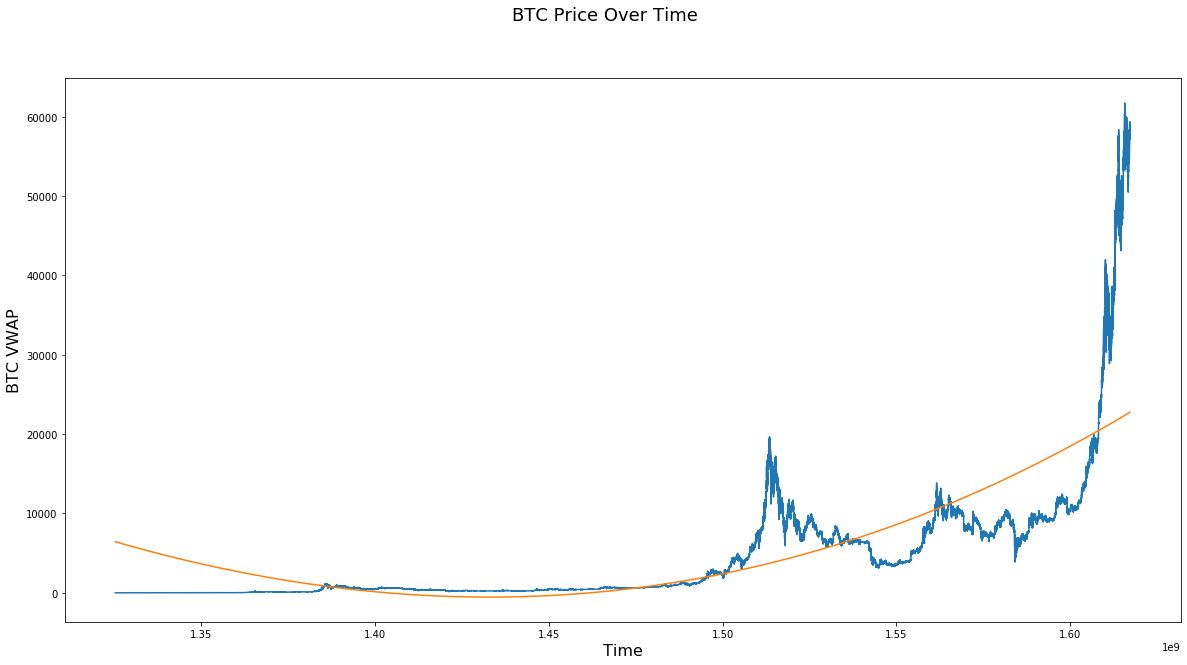

In [28]:
# 获取时间和价格
data_time = bitcoin_data['Timestamp'].values 
weighted_price = bitcoin_data['Weighted_Price'].values

# 设置画布
plt.figure(figsize=(20,10))
plt.plot(data_time,weighted_price)
plt.plot(data_time,model.predict(X))


# 其他参数
plt.xlabel('Time',fontsize=16)
plt.ylabel('BTC VWAP',fontsize=16)
plt.suptitle('BTC Price Over Time',fontsize=18)

plt.show()

# 时间序列分析

In [29]:
import statsmodels.api as sm

In [30]:
# 修改时间
bitcoin_data.Timestamp = pd.to_datetime(bitcoin_data.Timestamp, unit='s')
print(bitcoin_data)
# Resampling to daily frequency
bitcoin_data.index = bitcoin_data.Timestamp
bitcoin_data = bitcoin_data.resample('D').mean()

# Resampling to monthly frequency
bitcoin_data_month = bitcoin_data.resample('M').mean()

# Resampling to annual frequency
bitcoin_data_year = bitcoin_data.resample('A-DEC').mean()

# Resampling to quarterly frequency
bitcoin_data_Q = bitcoin_data.resample('Q-DEC').mean()
bitcoin_data

                  Timestamp      Open      High       Low     Close  \
0       2011-12-31 07:52:00      4.39      4.39      4.39      4.39   
478     2011-12-31 15:50:00      4.39      4.39      4.39      4.39   
547     2011-12-31 16:59:00      4.50      4.57      4.50      4.57   
548     2011-12-31 17:00:00      4.58      4.58      4.58      4.58   
1224    2012-01-01 04:16:00      4.58      4.58      4.58      4.58   
...                     ...       ...       ...       ...       ...   
4857372 2021-03-30 23:56:00  58714.31  58714.31  58686.00  58686.00   
4857373 2021-03-30 23:57:00  58683.97  58693.43  58683.97  58685.81   
4857374 2021-03-30 23:58:00  58693.43  58723.84  58693.43  58723.84   
4857375 2021-03-30 23:59:00  58742.18  58770.38  58742.18  58760.59   
4857376 2021-03-31 00:00:00  58767.75  58778.18  58755.97  58778.18   

         Volume_(BTC)  Volume_(Currency)  Weighted_Price  
0            0.455581           2.000000        4.390000  
478         48.000000        

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31,4.465000,4.482500,4.465000,4.482500,23.829470,106.330084,4.471603
2012-01-01,4.806667,4.806667,4.806667,4.806667,7.200667,35.259720,4.806667
2012-01-02,5.000000,5.000000,5.000000,5.000000,19.048000,95.240000,5.000000
2012-01-03,5.252500,5.252500,5.252500,5.252500,11.004660,58.100651,5.252500
2012-01-04,5.200000,5.223333,5.200000,5.223333,11.914807,63.119577,5.208159
...,...,...,...,...,...,...,...
2021-03-27,55193.240643,55219.665031,55168.757372,55195.415367,1.823877,100884.732367,55193.357260
2021-03-28,55833.608471,55857.735342,55810.425126,55835.012863,1.447939,80632.115263,55832.958824
2021-03-29,56914.886595,56946.213593,56885.242967,56915.629993,3.732887,213754.555988,56913.993819


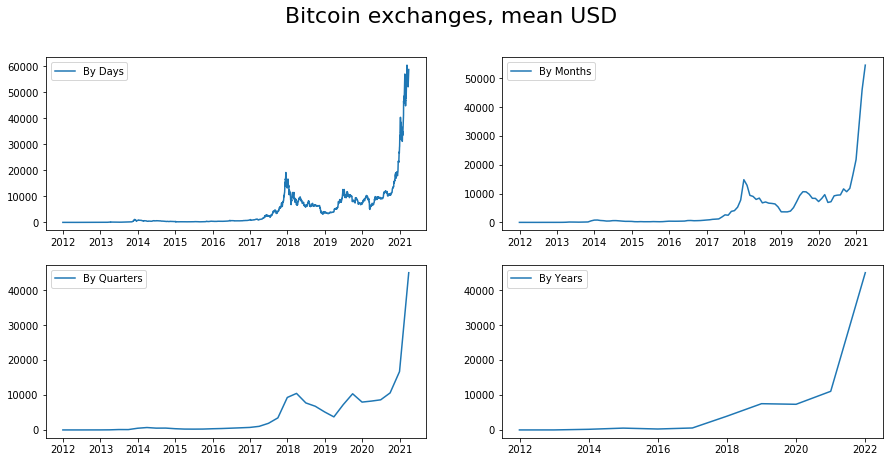

In [31]:
# PLOTS
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin exchanges, mean USD', fontsize=22)

plt.subplot(221)
plt.plot(bitcoin_data.Weighted_Price, '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(bitcoin_data_month.Weighted_Price, '-', label='By Months')
plt.legend()

plt.subplot(223)
plt.plot(bitcoin_data_Q.Weighted_Price, '-', label='By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(bitcoin_data_year.Weighted_Price, '-', label='By Years')
plt.legend()

# plt.tight_layout()
plt.show()

In [32]:
from scipy import stats

In [33]:
#讨论用月份的数据作为时间序列分析的对象
bitcoin_data_month.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31,4.465000,4.482500,4.465000,4.482500,23.829470,106.330084,4.471603
2012-01-31,6.208043,6.210657,6.205760,6.208932,5.411459,32.615170,6.208550
2012-02-29,5.253117,5.255079,5.250537,5.252514,8.398000,43.115105,5.252527
2012-03-31,4.963496,4.964408,4.960139,4.961054,15.830074,78.996873,4.962021
2012-04-30,4.976732,4.978059,4.975054,4.976416,19.889152,98.856816,4.976547


In [34]:
bitcoin_data_month.Weighted_Price

Timestamp
2011-12-31        4.471603
2012-01-31        6.208550
2012-02-29        5.252527
2012-03-31        4.962021
2012-04-30        4.976547
                  ...     
2020-11-30    16530.401656
2020-12-31    21810.922846
2021-01-31    34551.684656
2021-02-28    46074.940877
2021-03-31    54638.339142
Freq: M, Name: Weighted_Price, Length: 112, dtype: float64

## Time Series Decomposition with Moving Averages

$ Y[t] = T[t] + S[t] + e[t] $

长期趋势 T：现象在较长时期内受某种根本性因素作用而形成的总的变动趋势

季节变动 S：现象在一年内随着季节的变化而发生的有规律的周期性变动

C:\Users\12521\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  


<Figure size 1080x504 with 0 Axes>

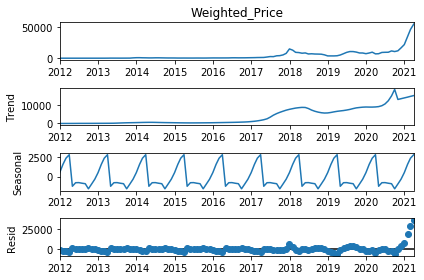

In [35]:
plt.figure(figsize=[15,7])
seasonal_decompose_result = sm.tsa.seasonal_decompose(bitcoin_data_month.Weighted_Price, freq=12, extrapolate_trend='freq')
seasonal_decompose_result.plot()
plt.show()

In [36]:
seasonal_decompose_pred = seasonal_decompose_result.trend + seasonal_decompose_result.seasonal

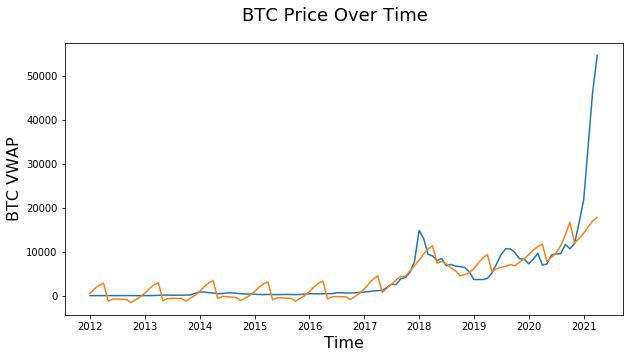

In [37]:
# 设置画布
plt.figure(figsize=(10,5))
plt.plot(bitcoin_data_month.Weighted_Price)
plt.plot(seasonal_decompose_pred)

# 其他参数
plt.xlabel('Time',fontsize=16)
plt.ylabel('BTC VWAP',fontsize=16)
plt.suptitle('BTC Price Over Time',fontsize=18)

plt.show()

## ARMA & ARIMA

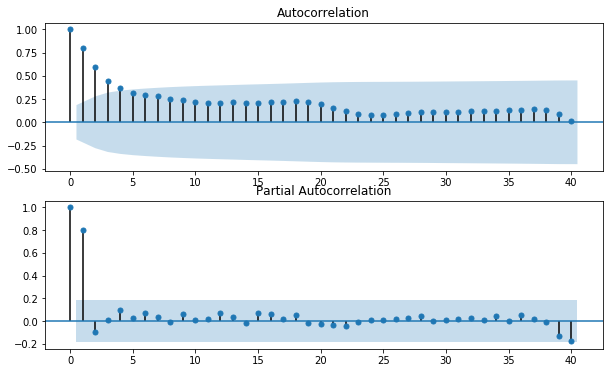

In [38]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(bitcoin_data_month.Weighted_Price.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(bitcoin_data_month.Weighted_Price, lags=40, ax=ax2)

In [39]:
from statsmodels.tsa.arima.model import ARIMA

In [40]:
dta = bitcoin_data_month.Weighted_Price

In [41]:
arma_mod20 = ARIMA(dta, order=(2, 0, 0)).fit()
print(arma_mod20.params)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


const     4.573616e+03
ar.L1     1.768051e+00
ar.L2    -7.748531e-01
sigma2    2.314379e+06
dtype: float64


In [42]:
# 评价参数
print(arma_mod20.aic, arma_mod20.bic, arma_mod20.hqic)

1973.8607126828492 1984.7347081680296 1978.2726383890156


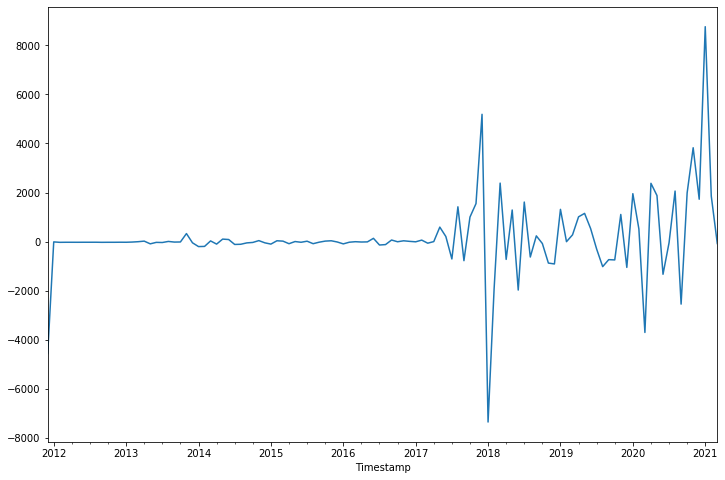

In [43]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax = arma_mod20.resid.plot(ax=ax);

In [44]:
arma_mod30 = ARIMA(dta, order=(3, 0, 0)).fit()
ARIMA?

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [45]:
print(arma_mod30.params)

const     4.573123e+03
ar.L1     1.731719e+00
ar.L2    -6.783406e-01
ar.L3    -6.071913e-02
sigma2    2.308501e+06
dtype: float64


In [46]:
print(arma_mod30.aic, arma_mod30.bic, arma_mod30.hqic)

1975.550697613155 1989.1431919696306 1981.065604745863


In [47]:
# Durbin–Watson statistic
sm.stats.durbin_watson(arma_mod30.resid.values)

1.9066063667353053

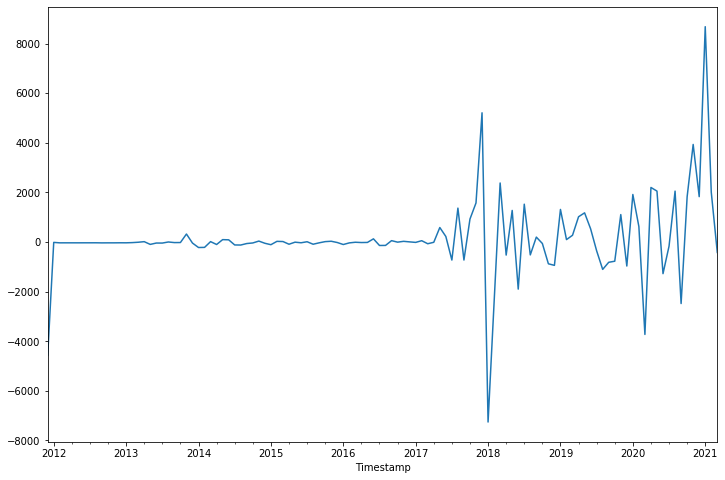

In [48]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax = arma_mod30.resid.plot(ax=ax);

In [49]:
resid = arma_mod30.resid

In [50]:
stats.normaltest(resid)

NormaltestResult(statistic=42.13116994662668, pvalue=7.101215429338037e-10)

In [51]:
from statsmodels.graphics.api import qqplot

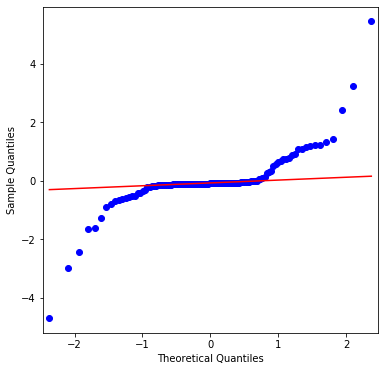

In [52]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
fig = qqplot(resid, line='q', ax=ax, fit=True)

# Model selection

In [53]:
from itertools import product

In [54]:
# Box-Cox Transformations
bitcoin_data_month['Weighted_Price_box'], lmbda = stats.boxcox(bitcoin_data_month.Weighted_Price)

In [55]:
# Initial approximation of parameters
qs = range(0, 3)
ps = range(0, 3)
d=1
parameters = product(ps, qs)
parameters_list = list(parameters)
print(parameters_list)
len(parameters_list)

[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]


9

In [56]:
bitcoin_data_month

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Weighted_Price_box
Timestamp,,,,,,,,
2011-12-31,4.465000,4.482500,4.465000,4.482500,23.829470,106.330084,4.471603,1.633994
2012-01-31,6.208043,6.210657,6.205760,6.208932,5.411459,32.615170,6.208550,2.031062
2012-02-29,5.253117,5.255079,5.250537,5.252514,8.398000,43.115105,5.252527,1.826878
2012-03-31,4.963496,4.964408,4.960139,4.961054,15.830074,78.996873,4.962021,1.758291
2012-04-30,4.976732,4.978059,4.975054,4.976416,19.889152,98.856816,4.976547,1.761804
...,...,...,...,...,...,...,...,...
2020-11-30,16530.188884,16540.060546,16519.995766,16530.432867,6.684712,110828.794944,16530.401656,17.836469
2020-12-31,21810.891586,21825.256165,21796.032856,21811.295270,5.740538,129193.865128,21810.922846,18.693975
2021-01-31,34553.473084,34593.508742,34511.853676,34553.599446,10.249651,352391.120149,34551.684656,20.178582


In [57]:
# Model Selection
results = []
best_aic = float("inf")
for param in parameters_list:
    try:
        model=ARIMA(bitcoin_data_month.Weighted_Price_box, order=(param[0], d, param[1])).fit()
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [58]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

  parameters         aic
3     (1, 0)  164.441796
7     (2, 1)  164.589209
4     (1, 1)  166.366073
6     (2, 0)  166.384849
8     (2, 2)  166.505751
                               SARIMAX Results                                
Dep. Variable:     Weighted_Price_box   No. Observations:                  112
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 -80.221
Date:                Fri, 25 Feb 2022   AIC                            164.442
Time:                        13:09:05   BIC                            169.861
Sample:                    12-31-2011   HQIC                           166.640
                         - 03-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4684      0.064      7.287      0.000      

In [59]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

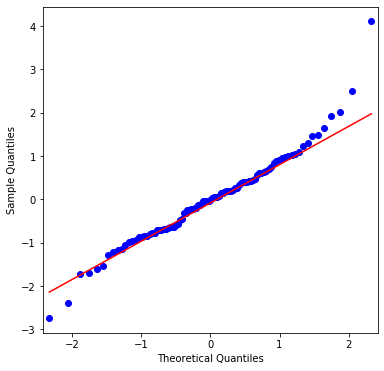

In [60]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
fig = qqplot(best_model.resid[13:].values.squeeze(), line='q', ax=ax, fit=True)

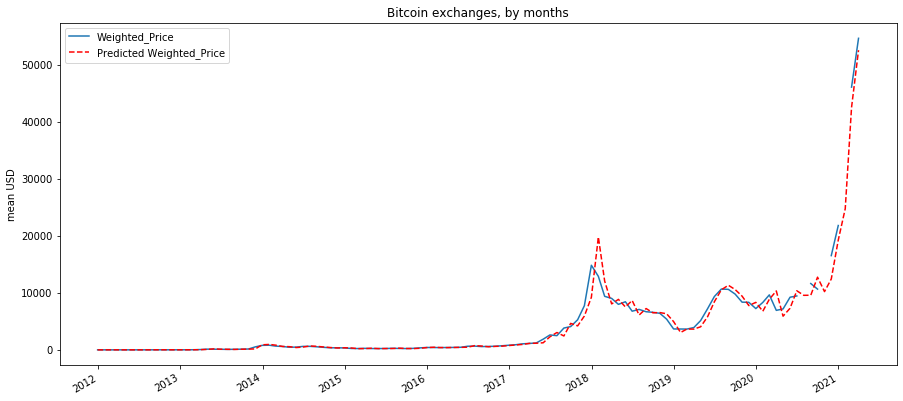

In [61]:
# Prediction
bitcoin_data_month2 = bitcoin_data_month[['Weighted_Price']]
date_list = [datetime(2020, 6, 30), datetime(2020, 7, 31), datetime(2020, 8, 31), datetime(2020, 9, 30), 
            datetime(2020, 10, 31), datetime(2020, 11, 30), datetime(2020, 12, 31), datetime(2021, 1, 31)]
future = pd.DataFrame(index=date_list, columns= bitcoin_data_month.columns)
bitcoin_data_month2 = pd.concat([bitcoin_data_month2, future])
bitcoin_data_month2['forecast'] = invboxcox(best_model.predict(start=0, end=len(bitcoin_data_month2)), lmbda)
plt.figure(figsize=(15,7))
bitcoin_data_month2.Weighted_Price.plot()
bitcoin_data_month2.forecast.plot(color='r', ls='--', label='Predicted Weighted_Price')
plt.legend()
plt.title('Bitcoin exchanges, by months')
plt.ylabel('mean USD')
plt.show()

In [62]:
# Add seasonal effect
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

54

In [63]:
# Model Selection
results = []
best_aic = float("inf")
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(bitcoin_data_month.Weighted_Price_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum

In [64]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters         aic
19  (1, 0, 0, 1)  173.616337
21  (1, 0, 1, 1)  174.766384
25  (1, 1, 0, 1)  175.547554
37  (2, 0, 0, 1)  175.554586
7   (0, 1, 0, 1)  175.588775
                                      SARIMAX Results                                       
Dep. Variable:                   Weighted_Price_box   No. Observations:                  112
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                 -83.808
Date:                              Fri, 25 Feb 2022   AIC                            173.616
Time:                                      13:09:47   BIC                            181.402
Sample:                                  12-31-2011   HQIC                           176.766
                                       - 03-31-2021                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---

Dickey–Fuller test:: p=0.000000


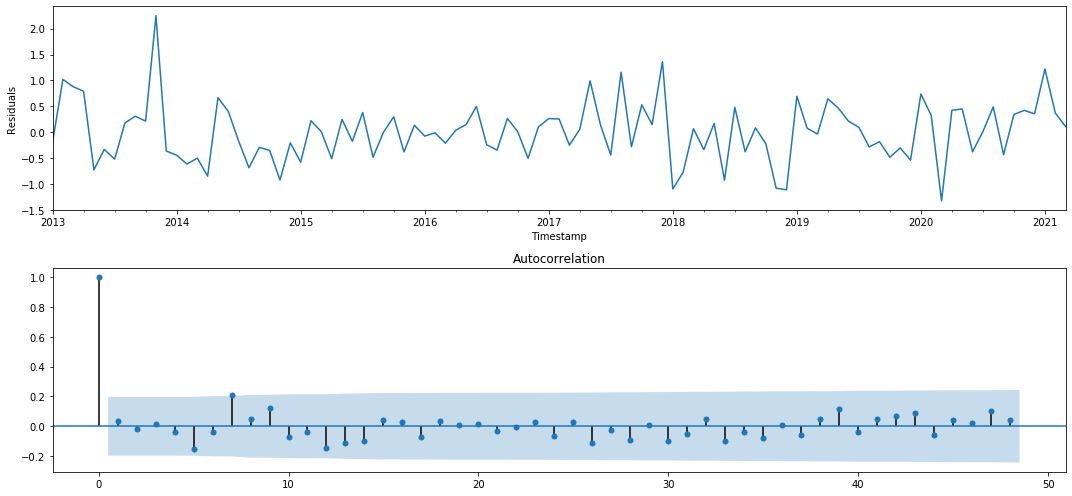

In [65]:
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()

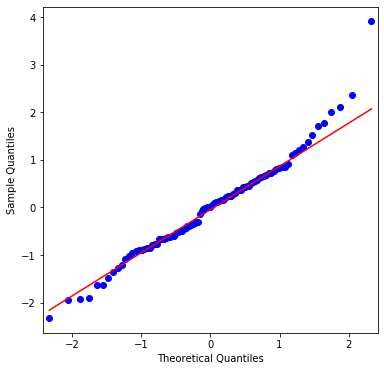

In [66]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
fig = qqplot(best_model.resid[13:].values.squeeze(), line='q', ax=ax, fit=True)

Compared with the previous figure, it can be seen that the distribution of points on the qq graph under the optimal SARIMA model is closer to a straight line through the origin than that under the optimal ARIMA model, indicating that the residual obtained by using the SARIMA model is more in line with the normal distribution. Therefore, it can be concluded that using SARIMA model for prediction is more reasonable

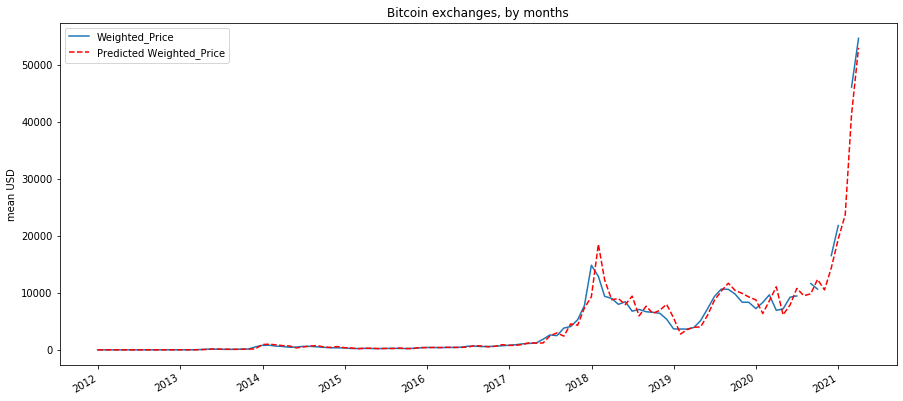

In [67]:
# Prediction
bitcoin_data_month3 = bitcoin_data_month[['Weighted_Price']]
date_list = [datetime(2020, 6, 30), datetime(2020, 7, 31), datetime(2020, 8, 31), datetime(2020, 9, 30), 
            datetime(2020, 10, 31), datetime(2020, 11, 30), datetime(2020, 12, 31), datetime(2021, 1, 31)]
future = pd.DataFrame(index=date_list, columns= bitcoin_data_month.columns)
bitcoin_data_month3 = pd.concat([bitcoin_data_month3, future])
bitcoin_data_month3['forecast'] = invboxcox(best_model.predict(start=0, end=len(bitcoin_data_month2)), lmbda)
plt.figure(figsize=(15,7))
bitcoin_data_month3.Weighted_Price.plot()
bitcoin_data_month3.forecast.plot(color='r', ls='--', label='Predicted Weighted_Price')
plt.legend()
plt.title('Bitcoin exchanges, by months')
plt.ylabel('mean USD')
plt.show()

It can be seen from the figure that SARIMA model has a higher degree of fitting to the data and a smaller prediction error.At the same time, it can also be concluded from the qq graph that the residual predicted by SARIMA model is closer to the normal distribution, which proves that SARIMA model is more reasonable. To sum up, SARIMA model is superior to ARIMA model in predicting the Weighted_Price of Bitcoin.